# Contextual bandit

What is the optimal policy for a one-dimensional contextual bandit environment with a bimodal reward-state distribution?

## Define environment

# Hyperparameters: constant

- Standard deviation of normal distributions $\sigma$
- Relative weightings of the two distributions in the mix $p$

### Hyperparameters: variable

- Midpoint between the means of the normal distributions
- Separation between the means of the normal distributions

### Parameters

- Environmental state (feature / context / cue) $s$ (see [Hyperparameters: variable](#hyperparameters-variable))
- Action choice $a$ 
- Probability of a reward $P(r|s,a)$
- Actual reward in a given instance $R(s,a)$

### Implications of single-timestep episodes

- There's no model of the environment because there are no state transitions (and episode initialisations are random)
- Could be considered a *nonstationary* problem because the expected rewards are changing each episode (even though the hyperdistribution from which those expected rewards are sampled is fixed)

In [15]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax.scipy.stats import norm
import jax.random

class BimodalBandit:
    def __init__(self, midpoint, distance, sigma=1, p=0.5, seed=0):
        self.midpoint = midpoint
        self.distance = distance
        self.p = p
        self.sigma = sigma
        self.mu1 = midpoint - distance / 2
        self.mu2 = midpoint + distance / 2
        self.key = jax.random.PRNGKey(seed)

    def pdf(self, action):
        pdf_value = self.p * norm.pdf(action, self.mu1, self.sigma) + \
                    (1 - self.p) * norm.pdf(action, self.mu2, self.sigma)
        return pdf_value

    def simulate_reward(self, action):
        self.key, subkey = jax.random.split(self.key)
        pdf_value = self.pdf(action)
        reward = jax.random.bernoulli(subkey, p=pdf_value).astype(int)
        return reward


# Create a BimodalBandit instance with a seed for reproducibility
midpoint = 0
distance = 4
bandit = BimodalBandit(midpoint=midpoint, distance=distance, seed=1)

# Generate values for plotting
action_values = jnp.linspace(-10, 10, 400)
pdf_values = jnp.array([bandit.pdf(action) for action in action_values])
bandit.key, seed = jax.random.split(bandit.key)
simulated_rewards = jnp.array([bandit.simulate_reward(action) for action in action_values])

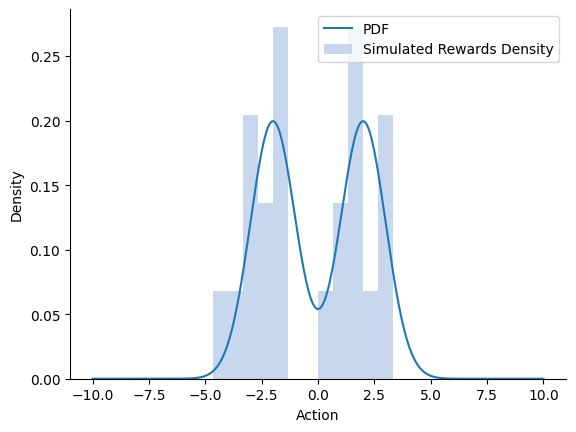

In [16]:
def plot_bimodal_bandit(action_values, pdf_values, simulated_rewards):
    fig, ax1 = plt.subplots()
    colors = ['#1f77b4', '#aec7e8']  # Blue color palette

    ax1.set_xlabel('Action')
    ax1.set_ylabel('Density')

    # Plot the PDF
    ax1.plot(action_values, pdf_values, color=colors[0], label='PDF')

    # Plot the histogram of simulated rewards with density=True
    ax1.hist(action_values, 
             weights=simulated_rewards, 
             bins=30, alpha=0.7, 
             color=colors[1], 
             density=True, 
             label='Simulated Rewards Density')

    # Add a legend
    ax1.legend()

    # Created L-shaped box
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

    plt.show()

# Call the plot_bimodal_bandit function
plot_bimodal_bandit(action_values, pdf_values, simulated_rewards)

## TODO

### Define policy
- Inputs: state $s$
- Outputs: action $a$

### Generate reward samples 
- Generate actions according to the policy
- Sample rewards from those actions

### Estimate value of actions
- Since each episode is one timestep, total return = reward at $t{0}$

### Update the policy 
- RL: gradient descent (batch size = full sample)
- EA: geometric mean?
- Minimax: regret

How should the EA and minimax updates be calculated?

### Action effects on environment (full MDP)
- Transition (environmental feedback) dynamics $P(s'|a,s)$
- Discount rate $\gamma$